In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numba import jit
from scipy import stats
from scipy.stats import ttest_ind
import time
import os

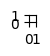

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

In [3]:
extinction_threshold = 0.1  # threshold below which a species is considered extinct

# getNFD.r

In [4]:
@jit(nopython=True)
def SOS(r1, r2, a11, a22, a12, a21):
#     The original code from Yenni et al. replaced r1 with r2:
#     S1 = r2 / (1 + (a12 / a22) * (r2 - 1))
#     S2 = r1 / (1 + (a21 / a11) * (r1 - 1))
    S1 = r1 / (1 + (a12 / a22) * (r2 - 1))
    S2 = r2 / (1 + (a21 / a11) * (r1 - 1))
    return S1, S2

@jit(nopython=True)
def get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, N1, N2):
    new_N = np.zeros(2)
    new_N[0] = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    new_N[1] = r2 * N2 / (1 + a21 * N1 + a22 * N2)
    out = np.zeros(2)
    out[0] = np.log(new_N[0]) - np.log(N1)  # per capita growth rate of species 1
    out[1] = np.log(new_N[1]) - np.log(N2)  # per capita growth rate of species 2
    return out

@jit(nopython=True)
def get_equilibrium_density(fixed_species, r1, r2, a11, a22, a12, a21, N_star):
    if fixed_species == 1:  # density of species 1 is known
        N2_star = (r2 - 1 - a21 * N_star) / a22
        return N2_star
    elif fixed_species == 2:  # density of species 2 is known
        N1_star = (r1 - 1 - a12 * N_star) / a11
        return N1_star
    else:
        raise ValueError("Invalid 'fixed_species' value. Must be either 1 or 2.")

@jit(nopython=True)
def calculate_frequency(N_focal, N_other):
    freq = N_focal / (N_focal + N_other)
    return freq

@jit(nopython=True)
def get_negative_frequency_dependence(r1, r2, a11, a22, a12, a21, lowN, highN):
    pgr1, freq1, pgr2, freq2 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)

    # Get low density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN[0] = lowN
    tmpN[1] = get_equilibrium_density(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[0] = tmpOut[0]
    freq1[0] = calculate_frequency(tmpN[0], tmpN[1])

    # Get low density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN
    tmpN[0] = get_equilibrium_density(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[1] = tmpOut[1]
    freq1[1] = calculate_frequency(tmpN[1], tmpN[0])

    # Get higher density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN[0] = highN
    tmpN[1] = get_equilibrium_density(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[0] = tmpOut[0]
    freq2[0] = calculate_frequency(tmpN[0], tmpN[1])

    # Get higher density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = highN
    tmpN[0] = get_equilibrium_density(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = get_per_capita_growth_rate(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[1] = tmpOut[1]
    freq2[1] = calculate_frequency(tmpN[1], tmpN[0])

    return {
        "pgr1": pgr1,
        "freq1": freq1,
        "pgr2": pgr2,
        "freq2": freq2
    }

# analyN_function.r

In [5]:
def analyN(r1, r2, a11, a22, a12, a21):
    tmax=1000
    N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
    N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)
    
    if np.isinf(N1) or np.isinf(N2) or np.isnan(N1) or np.isnan(N2):
        initialNsp1 = 0
        initialNsp2 = 0
        N = np.zeros((tmax, 2))
        N[0, :] = [initialNsp1, initialNsp2]
        
        for i in range(1, tmax):
            new_N1 = max((r1 - 1 - a12 * N[i-1, 1]) / a11, 0)
            new_N2 = max((r2 - 1 - a21 * N[i-1, 0]) / a22, 0)
            N[i, :] = [new_N1, new_N2]
        
        N1 = np.mean(N[:, 0])
        N2 = np.mean(N[:, 1])
    
    if N1 < 0:
        N1 = 0
        N2 = (r2 - 1) / a22
    
    if N2 < 0:
        N2 = 0
        N1 = (r1 - 1) / a11
    
    if N1 < extinction_threshold or N2 < extinction_threshold:
        return N1, N2, 0  # "Exclusion"
    else:
        return N1, N2, 1  # "Coexistence"

def analyN_calculation(r1, r2, a11, a22, a12, a21):
    # Initialize N1 and N2 to None
    N1, N2 = None, None
    Outcome = None  # Initialize Outcome to None
    
    # Solution 1: a12 * a21 != a11 * a22, a12 != 0, r1 * r2 != 0
    if a11 * a22 != a12 * a21 and a12 != 0 and r1 * r2 != 0:
        denominator = a11 * a22 - a12 * a21
        N1 = (a12 * (-r2) + a12 + a22 * (r1 - 1)) / denominator
        N2 = (a11 * (r2 - 1) + a21 * (-r1) + a21) / denominator
        Outcome = 1  # "Coexistence"
        return N1, N2, Outcome

    # Solution 2: a12 = 0, a11 != 0, a22 != 0, r1 * r2 != 0
    elif a12 == 0 and a11 != 0 and a22 != 0 and r1 * r2 != 0:
        N1 = (r1 - 1) / a11
        N2 = (a11 * (r2 - 1) + a21 * (-r1) + a21) / (a11 * a22)
        Outcome = 1  # "Coexistence"
        return N1, N2, Outcome

    # Solution 3: r1 = 1, a12 = 0, a11 = 0, a22 != 0, r2^2 != r2
    elif r1 == 1 and a12 == 0 and a11 == 0 and a22 != 0 and r2 ** 2 != r2:
        N2 = (-a21 + r2 - 1) / a22
        Outcome = None  # "Indeterminate"
        return None, N2, Outcome

    # Solution 4: r2 = 1, a22 = 0, a21 = 0, a12 != 0, r1^2 != r1
    elif r2 == 1 and a22 == 0 and a21 == 0 and a12 != 0 and r1 ** 2 != r1:
        N1 = (-a11 + r1 - 1) / a12
        Outcome = None  # "Indeterminate"
        return N1, None, Outcome

    # Solution 5: r2 = 1, r1 = 1, a22 != 0, a11 = (a12 * a21) / a22, a12 != 0
    elif r2 == 1 and r1 == 1 and a22 != 0 and a11 == (a12 * a21) / a22 and a12 != 0:
        N2 = -(a21) / a22
        Outcome = None  # "Indeterminate"
        return None, N2, Outcome

    # Solution 6: r2 != 1, a12 = (a22 * (r1 - 1)) / (r2 - 1), a22 != 0, a11 = (a21 * (r1 - 1)) / (r2 - 1), a22 * r1 != a22, r1 * r2 != 0
    elif r2 != 1 and a12 == (a22 * (r1 - 1)) / (r2 - 1) and a22 != 0 and a11 == (a21 * (r1 - 1)) / (r2 - 1) and a22 * r1 != a22 and r1 * r2 != 0:
        N2 = (-a21 + r2 - 1) / a22
        Outcome = None  # "Indeterminate"
        return None, N2, Outcome

    # Final checks for Outcome based on N1 and N2
    if N1 is None or N2 is None:
        Outcome = None  # "Indeterminate"
    elif N1 < extinction_threshold or N2 < extinction_threshold:
        Outcome = 0  # "Exclusion"
    else:
        Outcome = 1  # "Coexistence"

    return N1, N2, Outcome

In [6]:
@jit(nopython=True)
def time_simul(r1, r2, a11, a22, a12, a21):
    y01, y02 = 5, 5 # initial conditions
    
    y1 = np.array([y01], dtype=np.float64)
    y2 = np.array([y02], dtype=np.float64)
    i, stopRun = 0, 0
    
    while stopRun == 0:
        per_cap1 = r1 / (1 + a11 * y1[i] + a12 * y2[i])
        per_cap2 = r2 / (1 + a22 * y2[i] + a21 * y1[i])
        
        y1 = np.append(y1, y1[i] * per_cap1)
        y2 = np.append(y2, y2[i] * per_cap2)
        
        if np.abs(y1[-1] - y1[-2]) < 1.0e-5 and np.abs(y2[-1] - y2[-2]) < 1.0e-5:
            stopRun = 1
        i += 1
        if i > 1000:
            break
            
    if y1[-1] < extinction_threshold or y2[-1] < extinction_threshold:
        return y1, y2, 0 # "Exclusion"
    else:
        return y1, y2, 1 # "Coexistence"

# annualplant_2spp_det_par.r

In [7]:
# Simulation function
def Sim(mesh_row, calculation_method):
    r1, r2, a11, a22, a12, a21 = mesh_row
    N1, N2 = None, None  # Initialize to None
    
    if calculation_method == 'analyN':
        N1, N2, Outcome = analyN(r1, r2, a11, a22, a12, a21)
    elif calculation_method == 'time_simul':
        y1, y2, Outcome = time_simul(r1, r2, a11, a22, a12, a21)
        N1, N2 = y1[-1], y2[-1]
    else:
        raise ValueError("Invalid calculation method specified.")
    if N1 is None or N2 is None:
        return None 
    CoexistRank = 0 if N1 < 1 else 1
    S1, S2 = SOS(r1, r2, a11, a22, a12, a21)
    E1, E2 = r1 / r2, r2 / r1
    Asy = S1 - S2
    if N1 == 0 and N2 == 0:
        Rare = 0
    else:
        Rare = N1 / (N1 + N2)

    x = np.array([N1, N2])
    y = np.array([S1, S2])
    cov_matrix = np.cov(x, y)
    cor = cov_matrix[0, 1]
    
    if N1 / (N1 + N2) <= 0.25+0.0002:
        Rank = 2
    else:
        Rank = 1
    
    result_dict = {
        'r1': r1,
        'r2': r2,
        'a11': a11,
        'a22': a22,
        'a12': a12,
        'a21': a21,
        'N1': N1,
        'N2': N2,
        'Outcome': Outcome,
        'E1': E1,
        'E2': E2,
        'S1': S1,
        'S2': S2,
        'Rank': Rank,
        'CoexistRank': CoexistRank,
        'Asy': Asy,
        'cor': cor,
        'Rare': Rare
    }
    
    if calculation_method == time_simul:
        result_dict['y1_final'] = y1[-1]
        result_dict['y2_final'] = y2[-1]
    
    return result_dict

In [8]:
def run_simulation(mesh, calculation_method):
    n_rows = mesh.shape[0]
    results = []
    for k in range(n_rows):
        result_dict = Sim(mesh[k], calculation_method)
        results.append(result_dict)
    return results

# cor_figure.r

In [9]:
def filter_and_save_data(filename_analyN, filename_time_simul):
    for filename in [filename_analyN, filename_time_simul]:
        # Read the CSV file from the 'csv' folder
        dat_det = pd.read_csv(filename)
        dat_det = dat_det.query('Rank == 2 & S1 >= 1 & S2 >= 1')
        dat_det.reset_index(drop=True, inplace=True)
        
        x = dat_det[['N1', 'N2']].values
        y = dat_det[['S1', 'S2']].values
        dat_det['cor'] = [np.cov(x[i], y[i])[0, 1] for i in range(len(x))]
        
        # Overwrite the original file with the filtered data
        dat_det.to_csv(filename, index=False)

# figures_det.r

In [10]:
def perform_statistical_analysis(filename):
    filepath = os.path.join("csv", filename)
    dat = pd.read_csv(filepath)
    # Rename columns for better interpretability
    dat.rename(columns={'S1': 'Strength of Stabilization', 'E1': 'Fitness Equivalence', 'cor': '\u03BD'}, inplace=True)
    X = dat[['Strength of Stabilization', 'Fitness Equivalence', '\u03BD']]
    X = sm.add_constant(X)
    # Rename the constant to 'Intercept'
    X.rename(columns={'const': 'Intercept'}, inplace=True)
    y = dat['CoexistRank']
    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())

In [11]:
plt.rcParams['text.usetex'] = False

def plot_frequency_PGR(xspecies1, yspecies1, xspecies2, yspecies2, r1, r2, a11, a22, a12, a21):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.plot(xspecies1, yspecies1, color="r", label='$N_{1}$')
    plt.plot(xspecies2, yspecies2, color="b", label='$N_{2}$')
    plt.xlabel('Frequency')
    plt.ylabel('log(PGR)')
    # Define limits
    xlim = (-0.005, 1.01)
    ylim = (-1.01, 1.01)
    # Points for N_low* (left side)
    points_low = [
        (xspecies1[0], yspecies1[0]),
        (xspecies2[0], yspecies2[0])
    ]

#     # Adjustments for low labels to avoid overlap
#     offsets_low = [(0, -40), (0, -40)] # Further adjusted these values
#     offsets_high = [(-75, 35), (-75, 35)] # Further adjusted these values
    
    # Adjustments for low labels to avoid overlap
    offsets_low = [(0, -20), (0, -20)] # Further adjusted these values
    offsets_high = [(-75, 20), (-75, 20)] # Further adjusted these values

    # Calculate y-values for N_high* N1 at x = 1.01
    y_high_species1 = yspecies1[-1] + (yspecies1[-1] - yspecies1[-2]) / (xspecies1[-1] - xspecies1[-2]) * (xlim[1] - xspecies1[-1])
    y_high_species2 = yspecies2[-1] + (yspecies2[-1] - yspecies2[-2]) / (xspecies2[-1] - xspecies2[-2]) * (xlim[1] - xspecies2[-1])

    # Points for N_high* (right side)
    points_high = [
        (xlim[1]-0.009, y_high_species1+0.005), # Adjusted x-coordinate
        (xlim[1]-0.009, y_high_species2+0.005), # Adjusted x-coordinate
    ]
    labels_low = [r'$N_{2,low}^*$', r'$N_{1,low}^*$']
    labels_high = [r'$N_{2,high}^*$', r'$N_{1,high}^*$']
    for (x, y), label, offset in zip(points_low, labels_low, offsets_low):
        plt.scatter(x, y, color="b" if '1' in label else "r", s=100)
        plt.annotate(label, (x, y), xytext=offset, textcoords='offset points', fontsize=25)
    for (x, y), label, offset in zip(points_high, labels_high, offsets_high): # Added offset here
        plt.scatter(x, y, color="b" if '1' in label else "r", s=100)
        plt.annotate(label, (x, y), xytext=offset, textcoords='offset points', fontsize=25) # Used offset here
    plt.legend()
#     plt.title(
#         f"r1={r1:.1f}, r2={r2:.1f}, a11={a11:.1f}, a12={a12:.1f}, a21={a21:.1f}, a22={a22:.1f}",
#         wrap=True,
#         fontsize=25
#     )
    plt.tight_layout()
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.savefig(
        f"img/two_species_r1_{r1:.1f}_r2_{r2:.1f}_a11_{a11:.1f}_a12_{a12:.1f}_a21_{a21:.1f}_a22_{a22:.1f}_frequency_PGR.png",
        format='png',
        dpi=100,
        bbox_inches='tight' # Added this to ensure that the labels are not cut off
)    

In [12]:
@jit(nopython=True)
def define_parameters():
    r1_v = np.arange(15, 21)
    r2_v = np.arange(15, 21)
#     a11_v = np.arange(0.1, 3,0.1)
#     a12_v = np.arange(0.1, 1,0.1)
#     a21_v = np.arange(0.1, 1,0.1)
#     a22_v = np.arange(0.1, 1,0.1)
#     The original code from Yenni et al. employed these ranges:
    a11_v = np.array([0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3])
    a12_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    a21_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    a22_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    return r1_v, r2_v, a11_v, a12_v, a21_v, a22_v

def generate_mesh(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v):
    return np.array(np.meshgrid(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v)).T.reshape(-1, 6)

def save_results_to_csv(results, outfile):
    # Filter out None values
    filtered_results = [result for result in results if result is not None]
    # Convert the list of dictionaries to a DataFrame
    simul = pd.DataFrame(filtered_results)
    # Save the DataFrame to a CSV file
    simul.to_csv(outfile, index=False)

In [13]:
def count_variables_from_csv(filename):
    filepath = os.path.join("csv", filename)  # Construct the correct file path
    df = pd.read_csv(filepath)
    
    counters = [0] * 6  # Initialize counters

    for index, row in df.iterrows():
        outcome = row['Outcome']
        nu = row['cor']
        
        # Translate nu into the same categories as check_result
        tolerance = 0.05
        nu_category = 0 if abs(nu) < tolerance else (1 if nu > 0 else 2)
        
        # Update counters
        counters = update_counters(outcome, nu_category, counters)

    return counters

@jit(nopython=True)
def update_counters(outcome, nu_category, counters):
    nu_coexist_positive, nu_coexist_negative, nu_coexist_null, nu_exclude_positive, nu_exclude_negative, nu_exclude_null = counters
    
    if outcome == 1:
        if nu_category == 1:
            nu_coexist_positive += 1
        elif nu_category == 2:
            nu_coexist_negative += 1
        else:
            nu_coexist_null += 1
    else:
        if nu_category == 1:
            nu_exclude_positive += 1
        elif nu_category == 2:
            nu_exclude_negative += 1
        else:
            nu_exclude_null += 1
    
    return (nu_coexist_positive, nu_coexist_negative, nu_coexist_null, nu_exclude_positive, nu_exclude_negative, nu_exclude_null)

def print_counters(counters):
    nu_coexist_positive, nu_coexist_negative, nu_coexist_null, nu_exclude_positive, nu_exclude_negative, nu_exclude_null = counters
    total_cases = sum(counters)

    # Print the counts and percentages for nu
    print(f"\u03BD - Coexistence and Positive: {nu_coexist_positive} ({(nu_coexist_positive / total_cases) * 100:.2f}%)")
    print(f"\u03BD - Coexistence and Negative: {nu_coexist_negative} ({(nu_coexist_negative / total_cases) * 100:.2f}%)")
    print(f"\u03BD - Coexistence and Null: {nu_coexist_null} ({(nu_coexist_null / total_cases) * 100:.2f}%)")
    print(f"\u03BD - Exclusion and Positive: {nu_exclude_positive} ({(nu_exclude_positive / total_cases) * 100:.2f}%)")
    print(f"\u03BD - Exclusion and Negative: {nu_exclude_negative} ({(nu_exclude_negative / total_cases) * 100:.2f}%)")
    print(f"\u03BD - Exclusion and Null: {nu_exclude_null} ({(nu_exclude_null / total_cases) * 100:.2f}%)")

In [14]:
def main():
    # Ensure the 'csv' directory exists; if not, create it
    if not os.path.exists('csv'):
        os.makedirs('csv')
    
    # Capture the overall start time
    overall_start_time = time.time()
    
    # Define parameters and run simulation
    outfile = "annplant_2spp_det_rare"
    r1_v, r2_v, a11_v, a12_v, a21_v, a22_v = define_parameters()
    mesh = generate_mesh(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v)
    
    # Run simulation using analyN
    analyN_start_time = time.time()  # Capture the start time for analyN
    results_analyN = run_simulation(mesh, calculation_method='analyN')
    filename_analyN = os.path.join("csv", outfile + "_analyN.csv")
    save_results_to_csv(results_analyN, filename_analyN)
    analyN_end_time = time.time()  # Capture the end time for analyN
    analyN_elapsed_time = analyN_end_time - analyN_start_time  # Calculate the elapsed time for analyN
    print(f"The analyN simulation took {analyN_elapsed_time:.2f} seconds.")
    
    # Run simulation using time_simul
    time_simul_start_time = time.time()  # Capture the start time for time_simul
    results_time_simul = run_simulation(mesh, calculation_method='time_simul')
    filename_time_simul = os.path.join("csv", outfile + "_time_simul.csv")
    save_results_to_csv(results_time_simul, filename_time_simul)
    time_simul_end_time = time.time()  # Capture the end time for time_simul
    time_simul_elapsed_time = time_simul_end_time - time_simul_start_time  # Calculate the elapsed time for time_simul
    print(f"The time_simul simulation took {time_simul_elapsed_time:.2f} seconds.")
    
    # Perform statistical analysis
    perform_statistical_analysis("annplant_2spp_det_rare_analyN.csv")
    perform_statistical_analysis("annplant_2spp_det_rare_time_simul.csv")
    
    # Count variables from CSV files
    counters_analyN = count_variables_from_csv("annplant_2spp_det_rare_analyN.csv")
    counters_time_simul = count_variables_from_csv("annplant_2spp_det_rare_time_simul.csv")
    # Print the counts and percentages for nu (for each method)
    print("\nCounts and Percentages for analyN:")
    print_counters(counters_analyN)
    print("\nCounts and Percentages for time_simul:")
    print_counters(counters_time_simul)
    
    # Filter and save data
    filter_and_save_data(filename_analyN, filename_time_simul)
    
    # Capture the overall end time
    overall_end_time = time.time()
    overall_elapsed_time = overall_end_time - overall_start_time  # Calculate the overall elapsed time
    print(f"The overall simulation took {overall_elapsed_time:.2f} seconds.")

if __name__ == "__main__":
    main()

/tmp/ipykernel_178283/1890485974.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
/tmp/ipykernel_178283/1890485974.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)
/tmp/ipykernel_178283/1890485974.py:3: RuntimeWarning: invalid value encountered in double_scalars
  N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
/tmp/ipykernel_178283/1890485974.py:4: RuntimeWarning: invalid value encountered in double_scalars
  N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)
/tmp/ipykernel_178283/602718908.py:29: RuntimeWarning: invalid value encountered in double_scalars
  if N1 / (N1 + N2) <= 0.25+0.0002:


The analyN simulation took 8.10 seconds.
The time_simul simulation took 7.09 seconds.
                 Generalized Linear Model Regression Results                  
Dep. Variable:            CoexistRank   No. Observations:                69984
Model:                            GLM   Df Residuals:                    69980
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30367.
Date:                Tue, 03 Oct 2023   Deviance:                       60734.
Time:                        16:19:49   Pearson chi2:                 4.07e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3357
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

/home/tungdil/codes/Yenni/.env/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'counters' of function 'update_counters'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_178283/1977092314.py", line 20:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))



Counts and Percentages for analyN:
ν - Coexistence and Positive: 21268 (30.39%)
ν - Coexistence and Negative: 10529 (15.04%)
ν - Coexistence and Null: 1616 (2.31%)
ν - Exclusion and Positive: 24257 (34.66%)
ν - Exclusion and Negative: 12308 (17.59%)
ν - Exclusion and Null: 6 (0.01%)

Counts and Percentages for time_simul:
ν - Coexistence and Positive: 20160 (28.81%)
ν - Coexistence and Negative: 4680 (6.69%)
ν - Coexistence and Null: 1055 (1.51%)
ν - Exclusion and Positive: 43098 (61.58%)
ν - Exclusion and Negative: 924 (1.32%)
ν - Exclusion and Null: 67 (0.10%)


/tmp/ipykernel_178283/4289243623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_det['cor'] = [np.cov(x[i], y[i])[0, 1] for i in range(len(x))]


The overall simulation took 21.69 seconds.


/tmp/ipykernel_178283/4289243623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_det['cor'] = [np.cov(x[i], y[i])[0, 1] for i in range(len(x))]




Results for parameters: (15, 11, 0.7, 0.2, 0.2, 0.2)
Final abundance of Species 1: 8.000000000000002
Final abundance of Species 2: 41.99999999999999
Nu: 14.218181818181812
Calculation Method: analyN




Results for parameters: (15, 11, 0.7, 0.2, 0.2, 0.2)
Final abundance of Species 1: 8.000022328703503
Final abundance of Species 2: 41.99996847627457
Nu: 14.21815929807517
Calculation Method: time_simul




Results for parameters: (15, 11, 0.7, 0.6, 0.2, 0.1)
Final abundance of Species 1: 16.0
Final abundance of Species 2: 14.0
Nu: -0.20512820512820484
Calculation Method: analyN




Results for parameters: (15, 11, 0.7, 0.6, 0.2, 0.1)
Final abundance of Species 1: 15.999993793657394
Final abundance of Species 2: 14.000004553231044
Nu: -0.2051271015821895
Calculation Method: time_simul




Results for parameters: (15, 11, 2.3, 1, 0.5, 1)
Final abundance of Species 1: 5.000000000000001
Final abundance of Species 2: 5.0
Nu: 4.209311835695381e-16
Calculation Method: analyN




Results for 

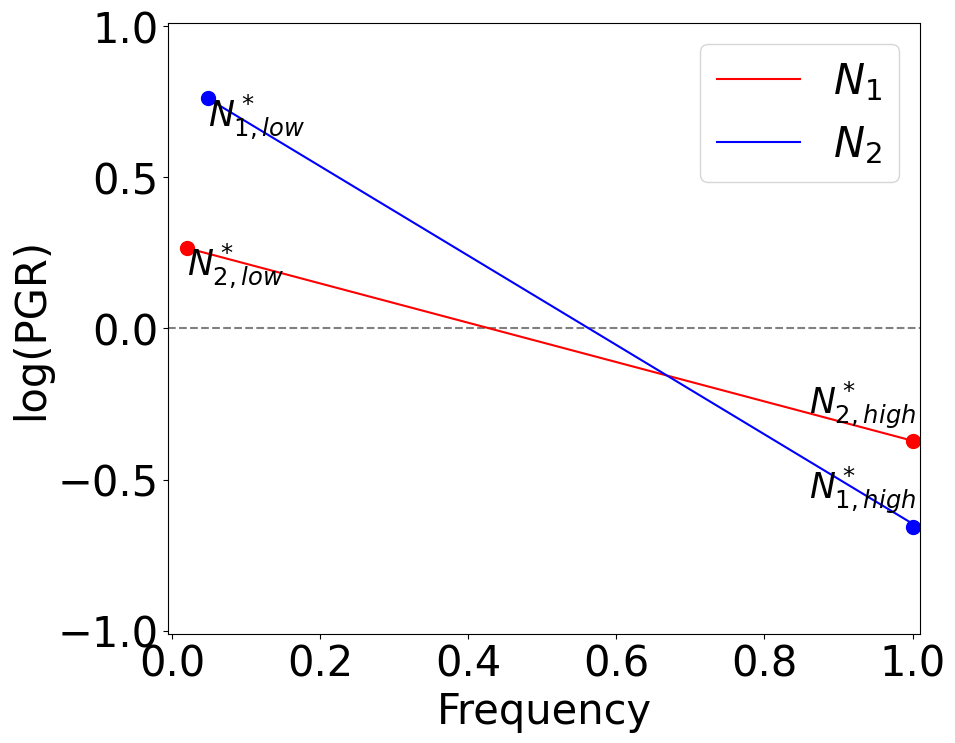

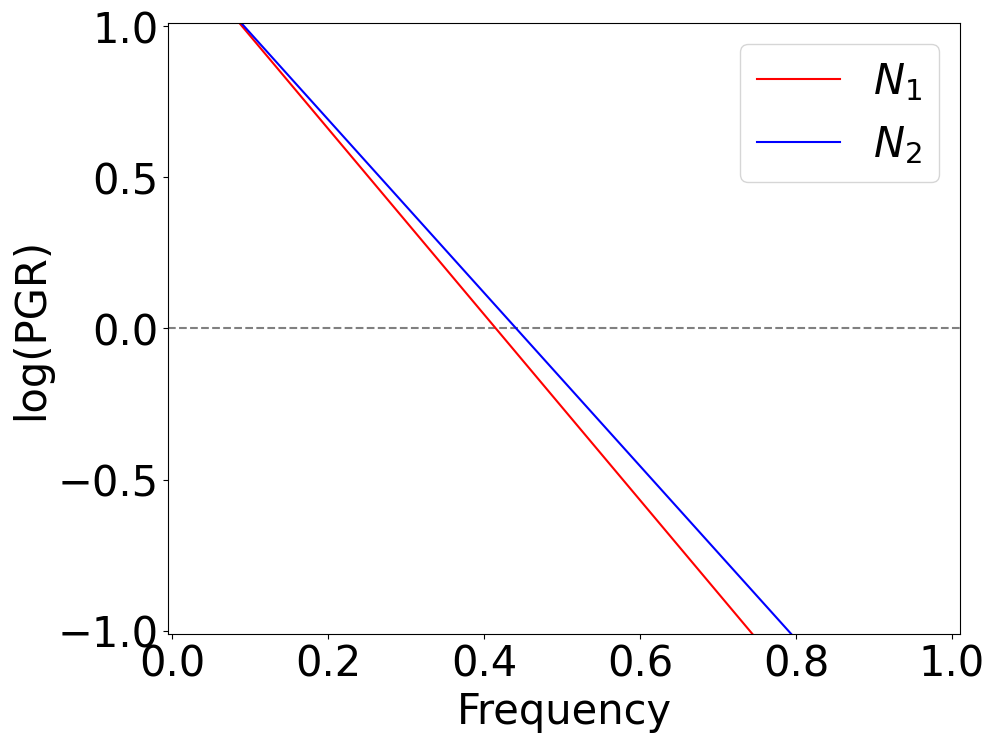

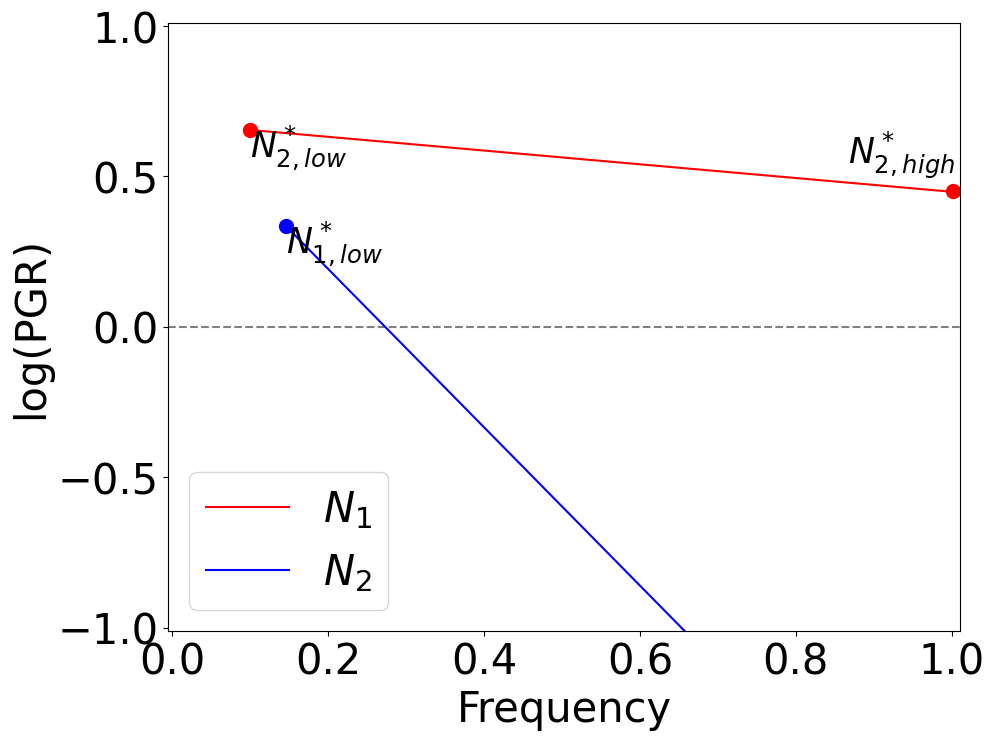

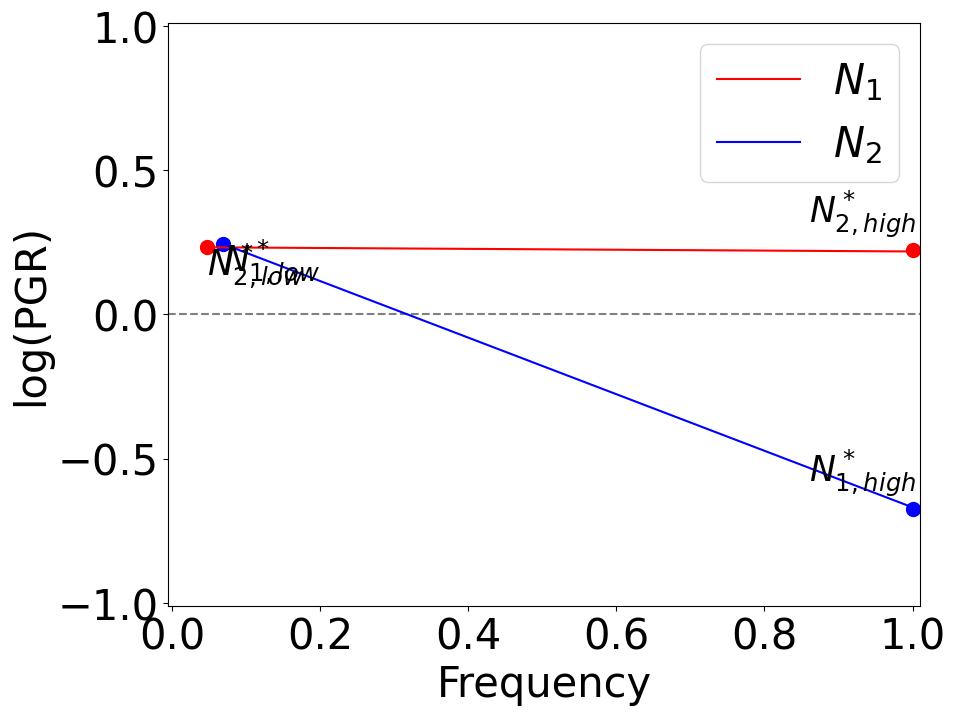

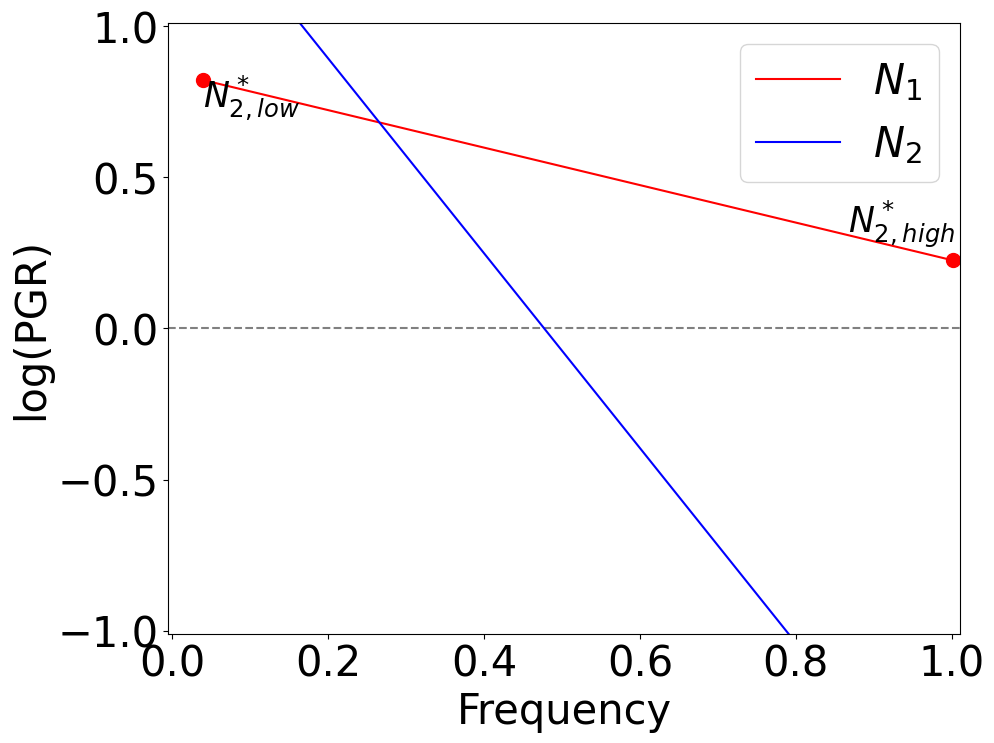

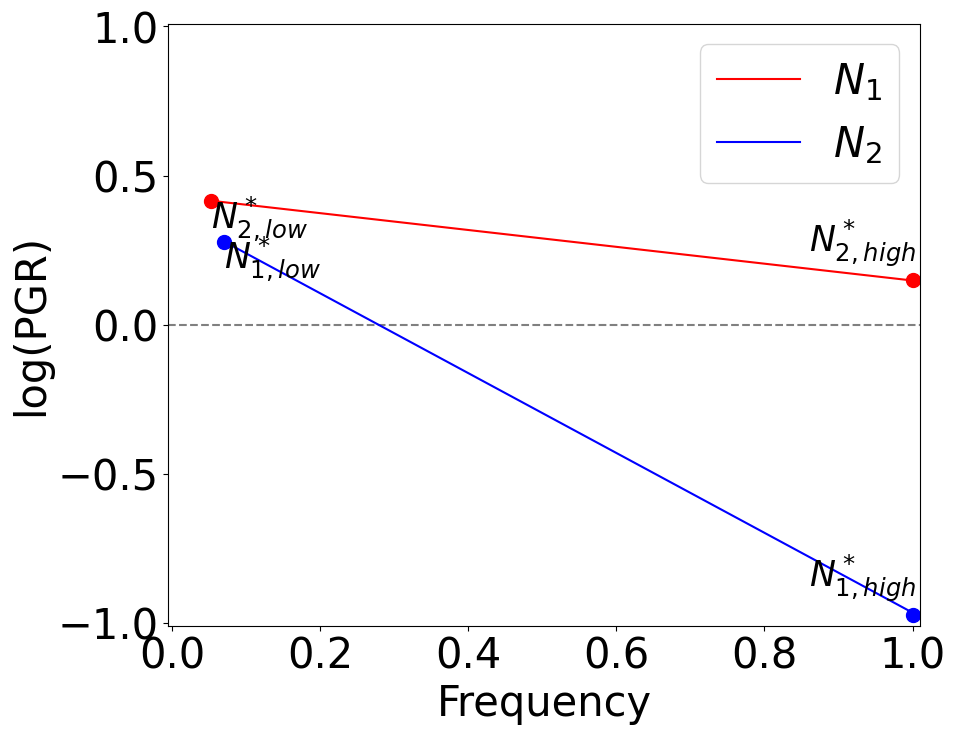

In [15]:
def test_parameters():
    if not os.path.exists('img'):
        os.makedirs('img')
    
    pars1 = 15, 15, 0.3, 0.1, 0.1, 0.1
    pars2 = 16, 15, 0.3, 0.1, 0.1, 0.1
    pars3 = 15, 11, 0.7, 0.2, 0.2, 0.2
    pars4 = 15, 11, 0.7, 0.3, 0.1, 0.1
    pars5 = 15, 11, 0.7, 0.6, 0.2, 0.1
    pars6 = 15, 11, 2.3, 1, 0.5, 1
    pars7 = 18, 18, 1.2, 0.8, 0.6, 0.9
    pars8 = 20, 16, 3, 0.6, 0.2, 0.6
    pars9 = 20, 20, 1.4, 1, 0.6, 1
    pars10 = 18, 16, 2, 1, 0.1, 0.8
    # Add more parameter sets as needed
    
    nu_values = []  # Initialize an empty list to store nu values
    
    lowN = 1  # Fixed small population
    highN = 160  # Fixed large population
    
    for pars in [pars3,pars5,pars6,pars7,pars8,pars9]:  # Add more parameter sets as needed
        r1, r2, a11, a22, a12, a21 = pars
        
        for calculation_method in ['analyN', 'time_simul']:
            sim_result = Sim(pars, calculation_method)
            cor = sim_result['cor']  # Access 'cor' using its key
            y1 = sim_result['N1']  # Final abundance of Species 1
            y2 = sim_result['N2']  # Final abundance of Species 2
            
            # Calculate negative frequency dependence
            test = get_negative_frequency_dependence(r1, r2, a11, a22, a12, a21, lowN, highN)
            
            # Extract per capita growth rates and frequencies
            pgr1 = np.array(test['pgr1'])
            pgr2 = np.array(test['pgr2'])
            freq1 = np.array(test['freq1'])
            freq2 = np.array(test['freq2'])
            
            # Prepare data for plotting
            xspecies1 = (freq1[0], freq2[0])
            yspecies1 = (pgr1[0], pgr2[0])
            xspecies2 = (freq1[1], freq2[1])
            yspecies2 = (pgr1[1], pgr2[1])
            
            # Calculate nu using the cor value from the Sim function
            nu = cor
            nu_values.append(nu)
            
            print("\n" + "="*53 + "\n")
            print(f"Results for parameters: {pars}")
            print(f"Final abundance of Species 1: {y1}")
            print(f"Final abundance of Species 2: {y2}")
            print(f"Nu: {nu}")
            print(f"Calculation Method: {calculation_method}")
            print("\n" + "="*53 + "\n")
            
        # Plotting
        plot_frequency_PGR(xspecies1, yspecies1, xspecies2, yspecies2, r1, r2, a11, a22, a12, a21)
        
    # Perform statistical analysis
    perform_statistical_analysis("annplant_2spp_det_rare_analyN.csv")
    perform_statistical_analysis("annplant_2spp_det_rare_time_simul.csv")
    
    # Count variables from CSV files
    counters_analyN = count_variables_from_csv("annplant_2spp_det_rare_analyN.csv")
    counters_time_simul = count_variables_from_csv("annplant_2spp_det_rare_time_simul.csv")

    # Print the counts and percentages for nu (for each method)
    print("\nCounts and Percentages for analyN:")
    print_counters(counters_analyN)
    print("\nCounts and Percentages for time_simul:")
    print_counters(counters_time_simul)
        
if __name__ == "__main__":
    test_parameters()
